### Ressources

https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

1ère étape
```python
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:]
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample
```

2ème étape:
```python
dataloader = DataLoader(transformed_dataset, batch_size=4,
                        shuffle=True, num_workers=0)
```

### Preprocessing

In [51]:
import pandas as pd
import logging
import numpy as np
import os
import matplotlib.pyplot as plt

logging.getLogger('matplotlib').setLevel(logging.ERROR)

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)


In [52]:
data = pd.read_csv("extract.csv", index_col=0)


In [53]:
# Processing
data = data.loc[data["battery_status"].isin(["Charging", "Discharging"])]
data["fans_rpm"] = data["fans_rpm"].fillna(data["mean_fans_rpm"])
battery_status = pd.get_dummies(data['battery_status'], prefix='battery_status')
os = pd.get_dummies(data['os'], prefix='os')
data = pd.concat([data, battery_status, os], axis=1)
# On drop manufacturer car problème en cas de nouveau manufacturer pour le modèle. Autre solution pour éviter cela: hasher les strings
data = data.drop(['battery_status', 'mean_fans_rpm', 'manufacturer', 'os'], axis = 1) 
data = data.sort_values(["time"])

data

,time,uuid,charge_full,current_now,voltage_min_design,n_running_threads,load_average_5,cpu_speed,load_average_1,voltage_now,...,ram_load,number_of_fans,capacity,charge_full_design,charge_now,load_average_15,battery_status_Charging,battery_status_Discharging,os_linux,os_macos
0,1.601834e+09,13370f11455f4f36a0680b9725189375,4089.0,2053.0,NaN,2846.0,2.64,NaN,2.52,12527.0,...,NaN,2.0,NaN,5088.0,3289.0,2.63,1,0,0,1
2,1.601834e+09,13370f11455f4f36a0680b9725189375,4089.0,2053.0,NaN,2837.0,2.62,NaN,2.45,12527.0,...,NaN,2.0,NaN,5088.0,3289.0,2.62,1,0,0,1
3,1.601834e+09,13370f11455f4f36a0680b9725189375,4089.0,1863.0,NaN,2804.0,2.63,NaN,2.57,12547.0,...,NaN,2.0,NaN,5088.0,3321.0,2.63,1,0,0,1
4,1.601834e+09,13370f11455f4f36a0680b9725189375,4089.0,1863.0,NaN,2794.0,2.72,NaN,2.99,12547.0,...,NaN,2.0,NaN,5088.0,3321.0,2.66,1,0,0,1
5,1.601834e+09,13370f11455f4f36a0680b9725189375,4089.0,1863.0,NaN,2783.0,2.81,NaN,3.29,12547.0,...,NaN,2.0,NaN,5088.0,3354.0,2.69,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,1.602147e+09,13370f11455f4f36a0680b9725189375,4036.0,1041.0,NaN,2973.0,3.21,NaN,2.62,12692.0,...,NaN,2.0,NaN,5088.0,3722.0,3.20,1,0,0,1
9995,1.602147e+09,13370f11455f4f36a0680b9725189375,4036.0,1041.0,NaN,2959.0,3.29,NaN,3.20,12692.0,...,NaN,2.0,NaN,5088.0,3722.0,3.23,1,0,0,1
9996,1.602147e+09,13370f11455f4f36a0680b9725189375,4036.0,993.0,NaN,2938.0,3.21,NaN,2.89,12690.0,...,NaN,2.0,NaN,5088.0,3739.0,3.20,1,0,0,1
9997,1.602147e+09,13370f11455f4f36a0680b9725189375,4036.0,993.0,NaN,3075.0,3.31,NaN,3.43,12690.0,...,NaN,2.0,NaN,5088.0,3739.0,3.24,1,0,0,1


DEBUG:root: - 4845 points
DEBUG:root:Extracted 27 sessions


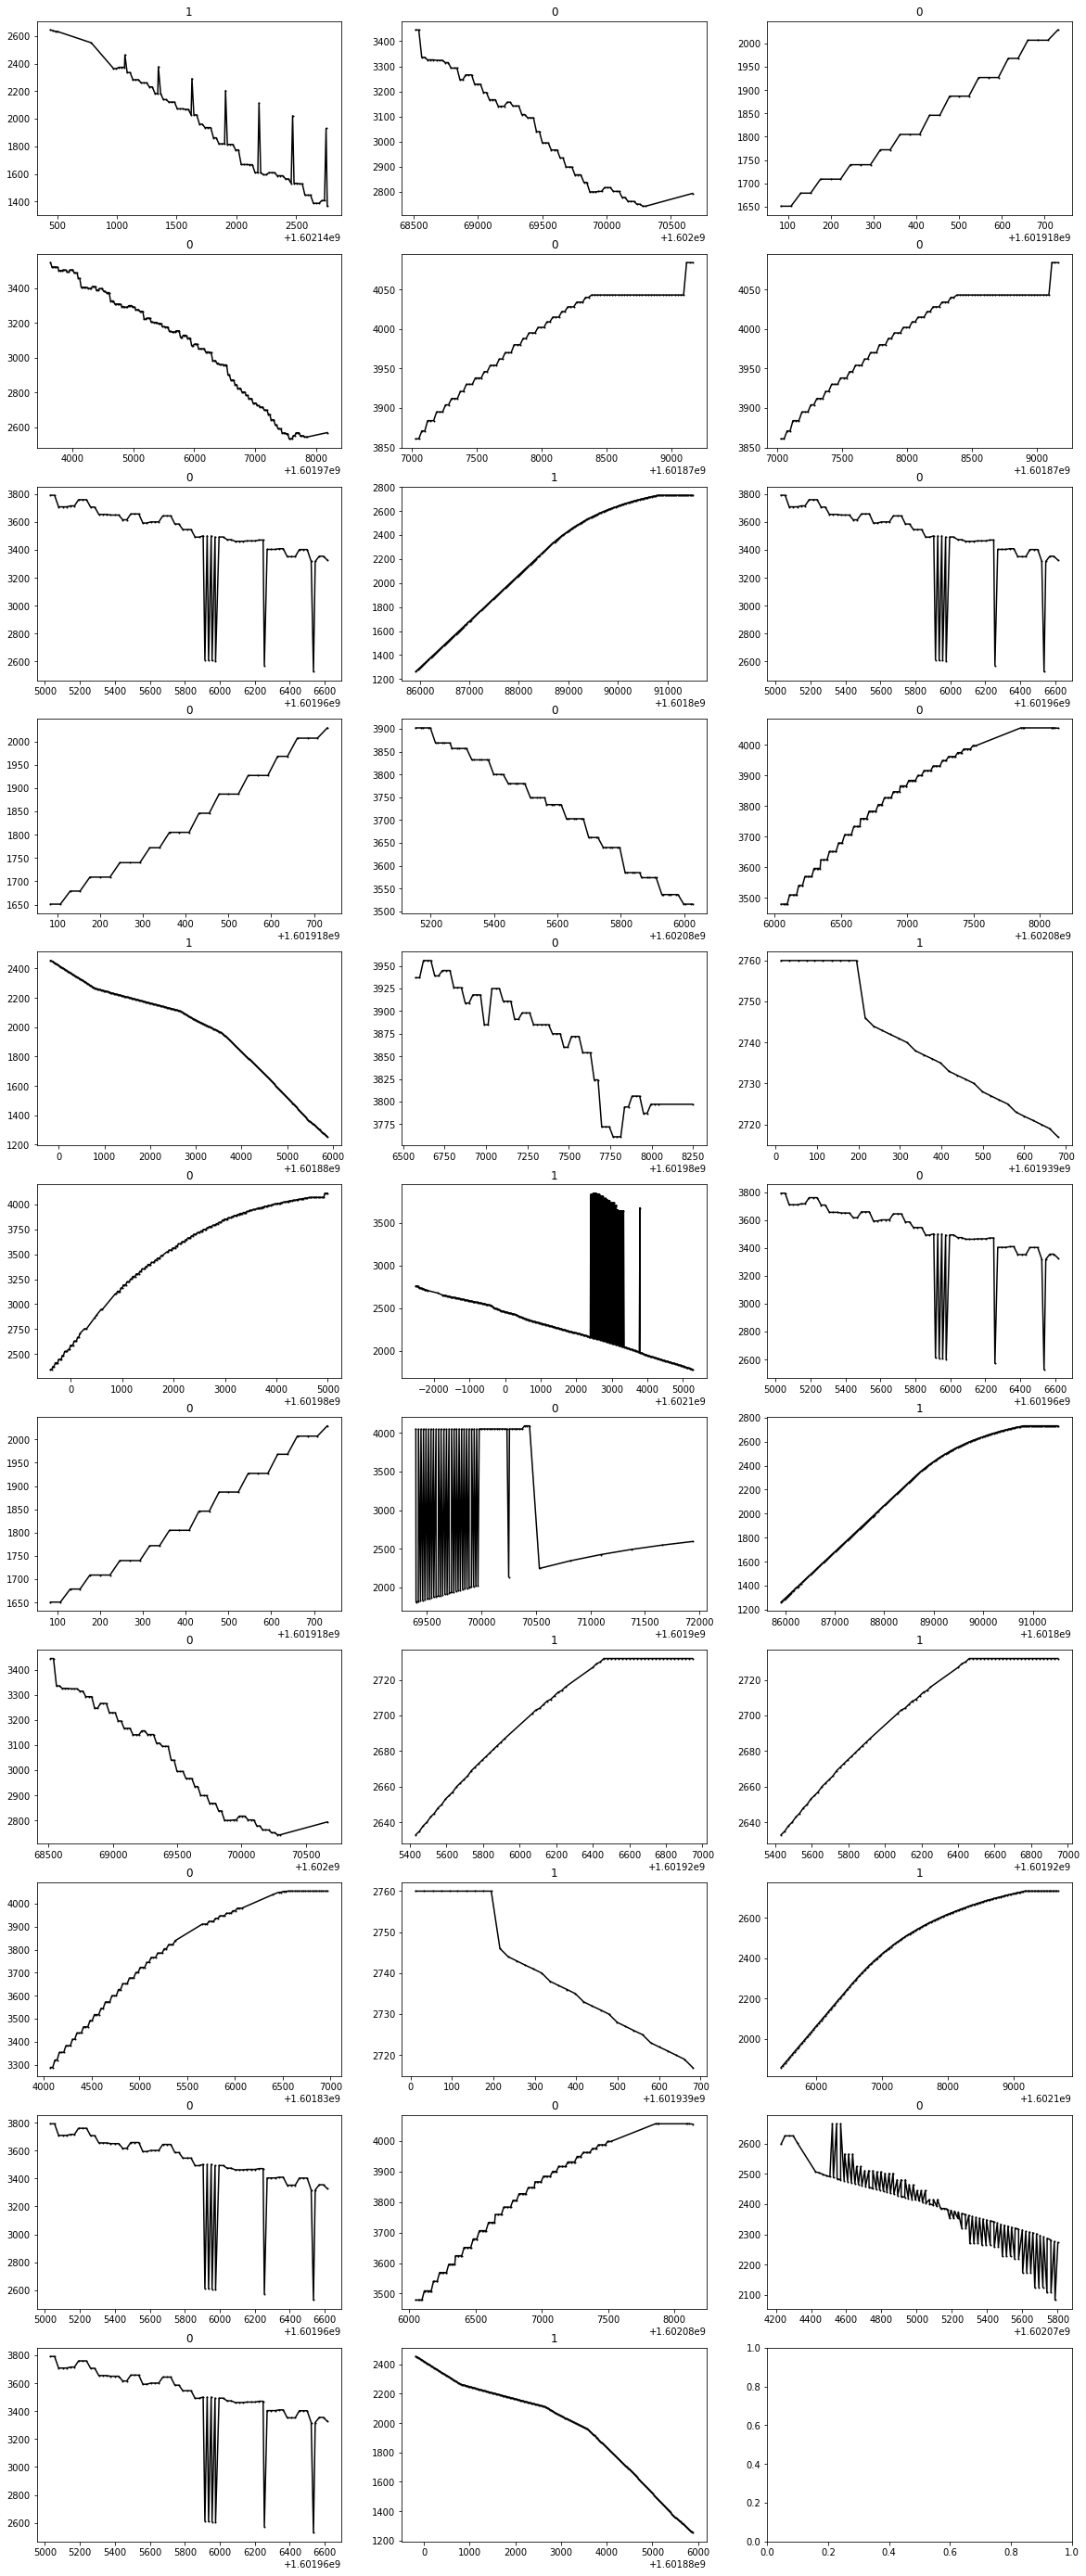

In [57]:
MAX_GAP_BETWEEN_SESSIONS = 400  # in seconds
MIN_NUM_POINTS_PER_SESSION = 10
MIN_SESSION_DURATION = 600 # in seconds


def extract_sessions(data):
    """Extract sessions.
    
    Args: 
        data (pd.DataFrame): data from one unique user (uuid 
            should be the same for all rows)
            
    Returns: 
        List of sessions (pd.Dataframes)
    """
    sessions = []

    logging.debug(f" - {len(data)} points")

    while len(data) != 0:
        # Initialize some variables
        session = []
        is_charging = data.iloc[0]["battery_status_Charging"]
        epoch = data.iloc[0]["time"]
        index = data.iloc[0].name
        session.append(data.iloc[0])

        # A session is ended with a:
        # * battery status change (from discharging to charging for eg)
        # * long enough gap between two consecutive data points
        for index_sess, row_sess in data[~data.index.isin([index])].iterrows():      
            last_index = index_sess
            if row_sess["battery_status_Charging"] != is_charging:
                break
            elif row_sess["time"] - epoch > MAX_GAP_BETWEEN_SESSIONS:
                break
            else:
                session.append(row_sess)
            epoch = row_sess["time"]

        # Remove all rows that were processed
        data = data[data.index > last_index]
        # Add session if it's long enough (w.r.t time and # of points)
        if (len(session) > MIN_NUM_POINTS_PER_SESSION) and \
          (session[-1]["time"] - session[0]["time"]) > MIN_SESSION_DURATION:
            # Add session to list
            sessions.append(session)

    logging.debug(f"Extracted {len(sessions)} sessions")
    sessions_df = [pd.DataFrame(session) for session in sessions]
    return sessions_df

sessions_df = extract_sessions(data)

n = 32
row, col = np.unravel_index([i for i in range(n)], ((n // 3) + 1, 3))
choice = np.random.randint(0, len(sessions_df), n)
sessions_df = np.array(sessions_df, dtype=object)
fig, axes = plt.subplots((n // 3) + 1, 3, 
    figsize=(20, (n // 3)*5))

for i, session_df in enumerate(sessions_df[choice]):
    axes[row[i], col[i]].set_title(f"{session_df.iloc[0]['os_linux']}")
    axes[row[i], col[i]].plot(session_df["time"], session_df["charge_now"], "ko-", markersize=1)

plt.show()

### Dataset

In [63]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import random

In [108]:
params = {
    "lower_bound": 0.2,
    "upper_bound": 0.5,
    "features": ['time',
                 'charge_full',
                 'current_now',
                 'n_running_threads',
                 'load_average_5',
                 'load_average_1',
                 'load_average_15',
                 'cpu_speed',
                 'voltage_now',
                 'cycle_count',
                 'battery_temp',
                 'cpu_temp',
                 'fans_rpm',
                 'ram_load',
                 'number_of_fans',
                 'capacity',
                 'charge_full_design',
                 'charge_now',
                 'battery_status_Charging',
                 'battery_status_Discharging',
                 'os_linux',
                 'os_macos']
}

In [109]:
class WindowDataset(Dataset):
    
    def __init__(self, sessions, params):
        self.sessions = sessions
        self.lower_bound = params["lower_bound"]
        self.upper_bound = params["upper_bound"]
        self.features = params["features"]

    def __len__(self):
        return len(self.sessions)

    def __getitem__(self, idx):
        ## Generate random number between 20-50%
        rand = random.uniform(self.lower_bound,self.upper_bound)
        ## Take the breakpoint number
        breakpoint = int(rand * len(self.sessions[idx]))
        ## Cut into inputs and labels
        data = self.sessions[idx][self.features]
        inputs = data[:breakpoint]
        labels = data[breakpoint:]
        return (inputs.values, labels.values)

        
        

In [110]:
#train_ds = WindowDataset(sessions_df, params)
#sample = train_ds[0]
#plt.plot(sample["time"], sample["charge_now"],'x')

In [111]:
dataloader = DataLoader(
            train_ds, batch_size=1,
            shuffle=True
        )

for inputs, labels in dataloader:
    print(inputs.shape)
    break;

torch.Size([1, 46, 22])


In [136]:
def create_data_loader(data, params, training):
    sessions_df = extract_sessions(data)
    dataset = WindowDataset(sessions_df, params)
    if training:
        dataloader = DataLoader(
            dataset, batch_size=1,
            shuffle=True,
        )
    else:
        raise Exception("Not yet implemented")
    return dataloader

dataloader = create_data_loader(data, params, True)

DEBUG:root: - 4845 points
DEBUG:root:Extracted 27 sessions


torch.Size([1, 28, 22])
torch.Size([1, 107, 22])


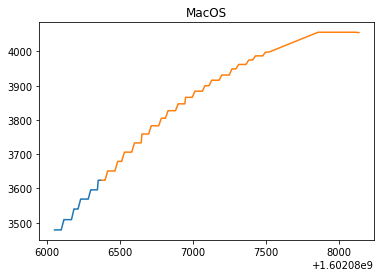

In [137]:
for inputs, labels in dataloader:
    print(inputs.shape)
    print(labels.shape)
    plt.plot(inputs[0, :, 0], inputs[0, :, 17])
    plt.plot(labels[0, :, 0], labels[0, :, 17])
    if inputs[0, -1, -1] == 1:
        plt.title("MacOS")
    else:
        plt.title("Linux")
    break